In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet101

: 

In [5]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

head = DeepLabHead(2048, 3)
head

DeepLabHead(
  (0): ASPP(
    (convs): ModuleList(
      (0): Sequential(
        (0): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ASPPConv(
        (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation=(12, 12), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): ASPPConv(
        (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(24, 24), dilation=(24, 24), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): ASPPConv(
        (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(36, 36), dilation=(36, 36), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [ ]:
model = deeplabv3_resnet101(weights='DEFAULT')
model

: 

In [5]:
model.classifier[4]

Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))

In [3]:
import torch
from config import config, update_config

import sys
sys.path.append('./') 

from datasets.pastis import PASTISReader
from utils import pad_collate
from utils import recursive2device

PATH_TO_CONFIG = '/home/fourier/paulo/biomass/Exchanger4SITS/configs/pastis/finetune/pastis_semseg_exchanger_unet_Fold0.yml'

class HelperConfig():
    def __init__(self, cfg, opts = []):
        self.cfg = cfg
        self.opts = opts

update_config(config, HelperConfig(PATH_TO_CONFIG))

n_fold = config.DATASET.N_FOLD
fold_sequence = [
    [[1, 2, 3], [4], [5]],
    [[2, 3, 4], [5], [1]],
    [[3, 4, 5], [1], [2]],
    [[4, 5, 1], [2], [3]],
    [[5, 1, 2], [3], [4]],
]
_, val_fold, _ = fold_sequence[n_fold]

batch_size = config.TRAIN.BATCH_SIZE_PER_GPU
dt = PASTISReader(config, nfolds=val_fold, mode='test')
dl = torch.utils.data.DataLoader(
    dt, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
iterator = dl.__iter__()

device = 'cuda'
device = torch.device(device)
batch = recursive2device(iterator.__next__(), device)


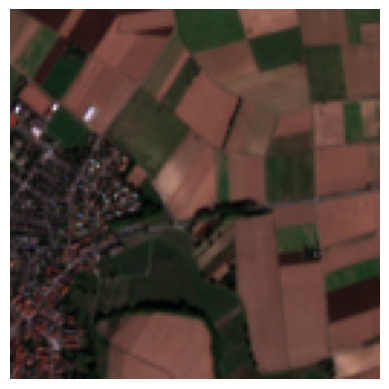

In [4]:
import numpy as np
from matplotlib import pyplot as plt

def get_rgb(x, b=0, t_show=6):
    """Gets an observation from a time series and normalises it for visualisation."""
    im = x[b, t_show, [2, 1, 0]].cpu().numpy()
    mx = im.max(axis=(1, 2))
    mi = im.min(axis=(1, 2))
    im = (im - mi[:, None, None])/(mx - mi)[:, None, None]
    im = im.swapaxes(0, 2).swapaxes(0, 1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

modality = config.DATASET.MODALITY[0]
ignore_index = -1

x = batch[f'data_{modality}'][:, :-1, ...].float()
labels = batch['label'][:, 0, ...].long() # [B, H, W]
spatial_pad_masks = batch['label'][:, -1, ...].bool()
y = labels.masked_fill(spatial_pad_masks, ignore_index)

b = 0
img = x.permute(0,2,1,3,4)
img = get_rgb(img, b, t_show=2)
label = y[b].cpu().numpy()

plt.imshow(img)
plt.axis('off')
plt.show()

In [17]:
model.eval()
model.to(device)
input = torch.tensor(img, device=device).permute(2,0,1).unsqueeze(0)

with torch.no_grad():
    pred = model(input)

In [34]:
# pred['out'][0][pred['out'].argmax(0) != 0]
pred['out'].argmax(1).shape

torch.Size([1, 128, 128])

In [ ]:
from losses import FocalCELoss

loss = FocalCELoss()

loss(pred['out'].argmax(1).unsqueeze(0), pred['aux'].argmax(1).unsqueeze(0))

In [33]:
labels = torch.tensor(label[:, 0, ...]).long() # [B, H, W]
spatial_pad_masks = torch.tensor(label[:, -1, ...]).bool()
labels = labels.masked_fill(spatial_pad_masks, -1)
labels.shape

torch.Size([128])